In [220]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('./data/csv/image-data.csv', usecols=['time', 'mean_gray'])

# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Add a new column 'image' with formatted 'time'
# df['image'] = df['time'].dt.strftime('%Y-%m-%d-%H-%M')

df.head()

,time,mean_gray
0,2024-06-28 22:59:15.651947,25.383881
1,2024-06-28 23:19:42.605933,25.088899
2,2024-06-28 23:20:15.055077,25.257823
3,2024-06-28 23:21:15.022617,25.119673
4,2024-06-28 23:22:15.022551,25.385512


In [221]:
df.describe()

,time,mean_gray
count,162303,162304.000000
mean,2024-08-27 03:19:45.906673664,31.232943
min,2024-06-28 22:59:15.651947,10.137477
25%,2024-07-27 10:49:11.845084160,20.126410
50%,2024-08-27 07:05:51.077687040,29.981545
75%,2024-09-24 22:54:21.142177024,40.670245
max,2024-11-01 13:20:35.303096,113.352662
std,NaN,14.144934


In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162304 entries, 0 to 162303
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   time       162303 non-null  datetime64[ns]
 1   mean_gray  162304 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.5 MB


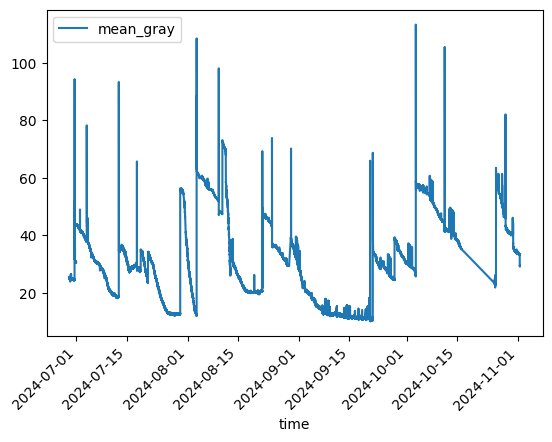

In [223]:
df.plot(x='time', y=['mean_gray'], kind='line')
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='time'>

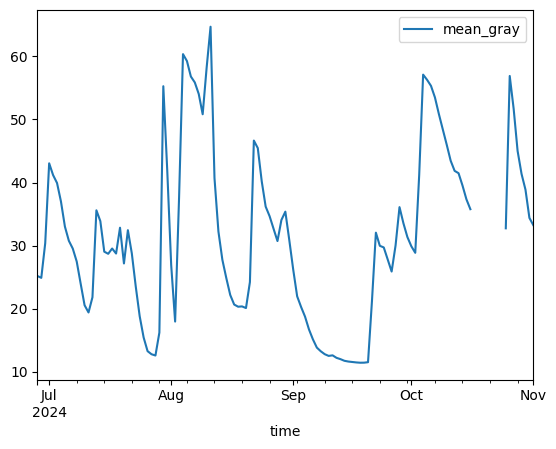

In [227]:
# Group by month and calculate the mean for 'mean_gray'
df_grouped = df.resample('D', on='time').mean()

# Plot the aggregated data
df_grouped[['mean_gray']].plot(kind='line')

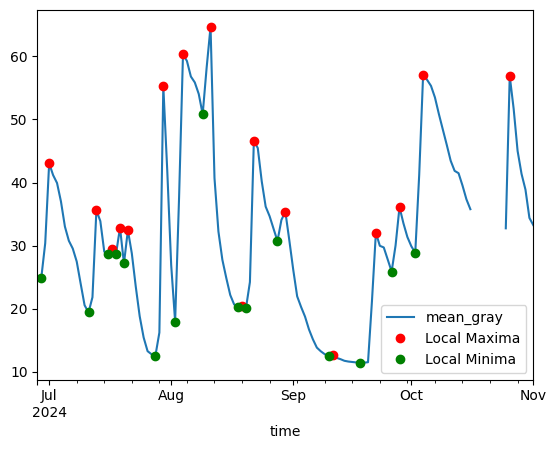

In [188]:
# Plot the aggregated data
fig, ax = plt.subplots()
df_grouped[['mean_gray']].plot(kind='line', ax=ax)

# Find all local maxima and minima
local_maxima = df_grouped[(df_grouped['mean_gray'].shift(1) < df_grouped['mean_gray']) & 
                          (df_grouped['mean_gray'].shift(-1) < df_grouped['mean_gray'])]

local_minima = df_grouped[(df_grouped['mean_gray'].shift(1) > df_grouped['mean_gray']) & 
                          (df_grouped['mean_gray'].shift(-1) > df_grouped['mean_gray'])]

# Plot all local maxima and minima
ax.plot(local_maxima.index, local_maxima['mean_gray'], 'ro', label='Local Maxima')
ax.plot(local_minima.index, local_minima['mean_gray'], 'go', label='Local Minima')

ax.legend()
plt.show()


In [181]:
local_maxima[['mean_gray']].head()

,mean_gray
time,
2024-06-30,94.396922
2024-07-03,78.295292
2024-07-12,93.401224
2024-07-17,65.763032
2024-07-21,34.377268


In [182]:
local_minima[['mean_gray']].head()

,mean_gray
time,
2024-07-01,43.922624
2024-07-11,19.837748
2024-07-16,29.283400
2024-07-20,34.191176
2024-07-28,13.029566


In [183]:
# Combine maxima and minima
combined = pd.concat([local_maxima, local_minima]).sort_index()

# Add a column to indicate if the point is a local maxima or minima
combined['extrema'] = ['maxima' if idx in local_maxima.index else 'minima' for idx in combined.index]

# Filter out minima that do not have a maxima before it
filtered_minima = combined[(combined['extrema'] == 'minima') & (combined.index > combined[combined['extrema'] == 'maxima'].index.min())]

# Filter out maxima that do not have a minima after it
filtered_maxima = combined[(combined['extrema'] == 'maxima') & (combined.index < combined[combined['extrema'] == 'minima'].index.max())]

# Combine the filtered maxima and minima
filtered_combined = pd.concat([filtered_maxima, filtered_minima]).sort_index()

# Define a minimum time difference threshold
time_threshold = pd.Timedelta(days=2)

# Remove maxima and minima that are close together time-wise
filtered_combined = filtered_combined[
    (filtered_combined.index.to_series().diff().abs() > time_threshold) | 
    (filtered_combined.index.to_series().diff(-1).abs() > time_threshold)
]

# Display the combined DataFrame
filtered_combined[['mean_gray', 'extrema']].head()

,mean_gray,extrema
time,,
2024-07-03,78.295292,maxima
2024-07-11,19.837748,minima
2024-07-12,93.401224,maxima
2024-07-16,29.283400,minima
2024-07-17,65.763032,maxima


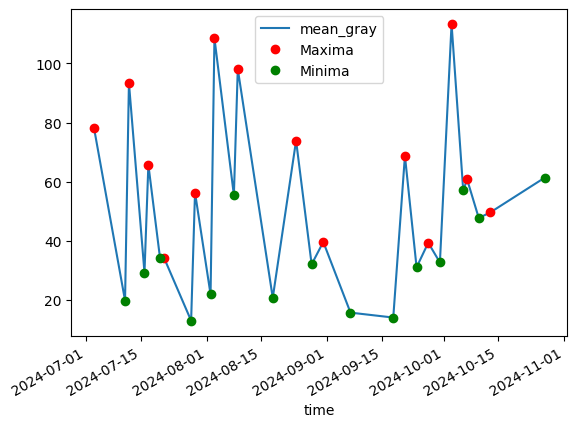

In [184]:
# Plot the filtered_combined DataFrame
ax = filtered_combined.plot(y='mean_gray', kind='line')

# Plot dots for maxima
ax.plot(filtered_combined[filtered_combined['extrema'] == 'maxima'].index, 
    filtered_combined[filtered_combined['extrema'] == 'maxima']['mean_gray'], 
    'ro', label='Maxima')

# Plot dots for minima
ax.plot(filtered_combined[filtered_combined['extrema'] == 'minima'].index, 
    filtered_combined[filtered_combined['extrema'] == 'minima']['mean_gray'], 
    'go', label='Minima')

# Add legend
ax.legend()
plt.show()

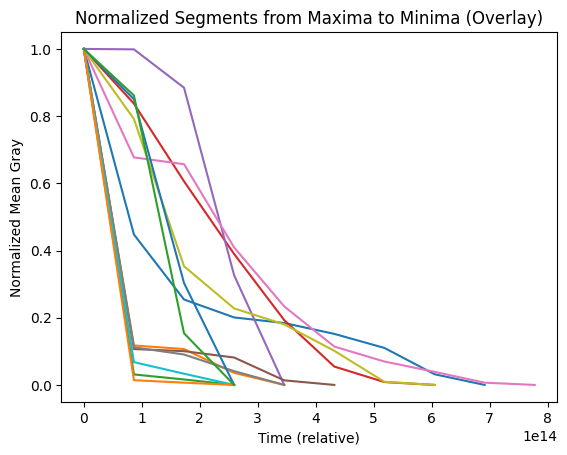

In [185]:
# Plot each line from maxima to minima over each other using index as x-axis
fig, ax = plt.subplots()

# Iterate through the filtered_combined DataFrame
for i in range(1, len(filtered_combined)):
    start = filtered_combined.index[i-1]
    end = filtered_combined.index[i]
    
    # Extract the segment between the current maxima and minima
    segment = df_grouped.loc[start:end, 'mean_gray']
    
    # Normalize the segment
    normalized_segment = (segment - segment.min()) / (segment.max() - segment.min())
    
    # Only plot segments that start at 1 for Y axis
    if normalized_segment.iloc[0] == 1:
        # Plot the normalized segment using the index as x-axis
        ax.plot(normalized_segment.index - normalized_segment.index[0], normalized_segment.values)

# Add labels and title
ax.set_xlabel('Time (relative)')
ax.set_ylabel('Normalized Mean Gray')
ax.set_title('Normalized Segments from Maxima to Minima (Overlay)')

plt.show()

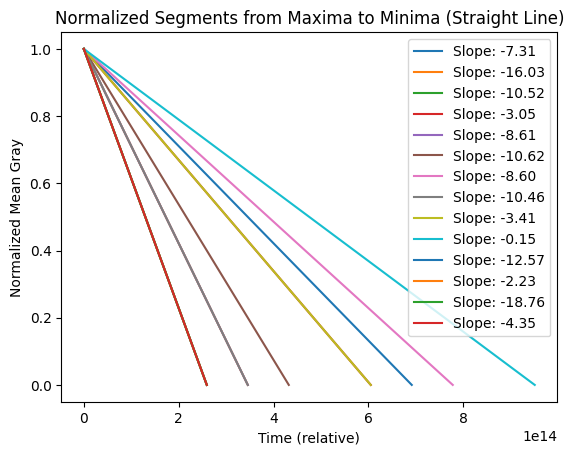

In [186]:
# Plot each line from maxima to minima over each other using index as x-axis
fig, ax = plt.subplots()

# Iterate through the filtered_combined DataFrame
for i in range(1, len(filtered_combined)):
    start = filtered_combined.index[i-1]
    end = filtered_combined.index[i]
    
    # Extract the values at the start and end points
    start_value = filtered_combined.loc[start, 'mean_gray']
    end_value = filtered_combined.loc[end, 'mean_gray']
    
    # Create a straight line segment
    line_segment = pd.Series([start_value, end_value], index=[start, end])
    
    # Normalize the segment
    normalized_segment = (line_segment - line_segment.min()) / (line_segment.max() - line_segment.min())
    
    # Only plot segments that start at 1 for Y axis
    if normalized_segment.iloc[0] == 1:
        # Calculate the slope
        delta_y = end_value - start_value
        delta_x = (end - start).days
        slope = delta_y / delta_x if delta_x != 0 else float('inf')
        
        # Plot the normalized segment using the index as x-axis
        ax.plot(normalized_segment.index - normalized_segment.index[0], normalized_segment.values, label=f'Slope: {slope:.2f}')
        
# Add labels, title, and legend
ax.set_xlabel('Time (relative)')
ax.set_ylabel('Normalized Mean Gray')
ax.set_title('Normalized Segments from Maxima to Minima (Straight Line)')
ax.legend()

plt.show()


In [233]:
# Initialize an empty list to store the results
slopes = []

# Iterate through the filtered_combined DataFrame
for i in range(1, len(filtered_combined)):
    if filtered_combined['extrema'].iloc[i-1] == 'maxima' and filtered_combined['extrema'].iloc[i] == 'minima':
        start = filtered_combined.index[i-1]
        end = filtered_combined.index[i]
        
        # Calculate the slope
        delta_y = filtered_combined.loc[end, 'mean_gray'] - filtered_combined.loc[start, 'mean_gray']
        delta_x = (end - start).days
        slope = delta_y / delta_x if delta_x != 0 else float('inf')
        
        # Append the result to the list
        slopes.append({
            'maxima_time': start,
            'minima_time': end,
            'slope': slope
        })

# Convert the list to a DataFrame
slopes_df = pd.DataFrame(slopes)

# Add a column with the week number
slopes_df['week_number'] = slopes_df['maxima_time'].dt.isocalendar().week



# Display the DataFrame
slopes_df

,maxima_time,minima_time,slope,week_number
0,2024-07-03,2024-07-11,-7.307193,27
1,2024-07-12,2024-07-16,-16.029456,28
2,2024-07-17,2024-07-20,-10.523952,29
3,2024-07-21,2024-07-28,-3.049672,29
4,2024-07-29,2024-08-02,-8.609086,31
5,2024-08-03,2024-08-08,-10.615178,31
6,2024-08-09,2024-08-18,-8.595404,32
7,2024-08-24,2024-08-28,-10.457091,34
8,2024-08-31,2024-09-07,-3.414258,35
9,2024-09-21,2024-09-24,-12.565729,38


In [241]:
# Order the slopes_df DataFrame by the slope column
slopes_df_sorted = slopes_df.sort_values(by='slope')

# Display the sorted DataFrame
slopes_df_sorted

,maxima_time,minima_time,slope,week_number
11,2024-10-03,2024-10-06,-18.761883,40
1,2024-07-12,2024-07-16,-16.029456,28
9,2024-09-21,2024-09-24,-12.565729,38
5,2024-08-03,2024-08-08,-10.615178,31
2,2024-07-17,2024-07-20,-10.523952,29
7,2024-08-24,2024-08-28,-10.457091,34
4,2024-07-29,2024-08-02,-8.609086,31
6,2024-08-09,2024-08-18,-8.595404,32
0,2024-07-03,2024-07-11,-7.307193,27
12,2024-10-07,2024-10-10,-4.348632,41


In [242]:
# Get the row with the maximum mean_gray value for each day
df_grouped_max = df.loc[df.groupby(df['time'].dt.date)['mean_gray'].idxmax()]
df_grouped_max['image'] = df_grouped_max['time'].dt.strftime('%Y-%m-%d-%H-%M')
df_grouped_max['day'] = df_grouped_max['time'].dt.strftime('%Y-%m-%d')
df_grouped_max.head()

,time,mean_gray,image,day
4,2024-06-28 23:22:15.022551,25.385512,2024-06-28-23-22,2024-06-28
798,2024-06-29 12:35:15.022688,26.621639,2024-06-29-12-35,2024-06-29
1771,2024-06-30 12:07:14.703910,94.396922,2024-06-30-12-07,2024-06-30
2701,2024-07-01 03:36:41.873197,43.922624,2024-07-01-03-36,2024-07-01
3933,2024-07-02 00:08:42.124027,49.043482,2024-07-02-00-08,2024-07-02


In [244]:
# Convert 'day' column in df_grouped_max to datetime for accurate merging
df_grouped_max['day'] = pd.to_datetime(df_grouped_max['day'])

# Merge the dataframes on 'day' and 'maxima_time'
merged_df = pd.merge(df_grouped_max, slopes_df_sorted, left_on='day', right_on='maxima_time')

# Display the merged dataframe
merged_df

,time,mean_gray,image,day,maxima_time,minima_time,slope,week_number
0,2024-07-03 21:10:41.683308,78.295292,2024-07-03-21-10,2024-07-03,2024-07-03,2024-07-11,-7.307193,27
1,2024-07-12 19:32:41.972207,93.401224,2024-07-12-19-32,2024-07-12,2024-07-12,2024-07-16,-16.029456,28
2,2024-07-17 20:44:41.781722,65.763032,2024-07-17-20-44,2024-07-17,2024-07-17,2024-07-20,-10.523952,29
3,2024-07-21 00:24:07.023220,34.377268,2024-07-21-00-24,2024-07-21,2024-07-21,2024-07-28,-3.049672,29
4,2024-07-29 22:06:41.761890,56.365171,2024-07-29-22-06,2024-07-29,2024-07-29,2024-08-02,-8.609086,31
5,2024-08-03 11:53:41.803669,108.542549,2024-08-03-11-53,2024-08-03,2024-08-03,2024-08-08,-10.615178,31
6,2024-08-09 15:51:39.230011,98.137933,2024-08-09-15-51,2024-08-09,2024-08-09,2024-08-18,-8.595404,32
7,2024-08-24 11:37:51.127526,73.912231,2024-08-24-11-37,2024-08-24,2024-08-24,2024-08-28,-10.457091,34
8,2024-08-31 03:35:51.050426,39.656522,2024-08-31-03-35,2024-08-31,2024-08-31,2024-09-07,-3.414258,35
9,2024-09-21 13:35:51.304357,68.773909,2024-09-21-13-35,2024-09-21,2024-09-21,2024-09-24,-12.565729,38


In [235]:
# Get the row with the minimum mean_gray value for each day
df_grouped_min = df.loc[df.groupby(df['time'].dt.date)['mean_gray'].2024-07-03-21-10idxmin()]
df_grouped_min['image'] = df_grouped_min['time'].dt.strftime('%Y-%m-%d-%H-%M')
df_grouped_min.head()

,time,mean_gray,image
38,2024-06-28 23:56:14.858538,25.004537,2024-06-28-23-56
467,2024-06-29 07:05:14.826436,23.963223,2024-06-29-07-05
1497,2024-06-30 07:33:15.054703,24.393141,2024-06-30-07-33
3921,2024-07-01 23:56:41.905470,41.830189,2024-07-01-23-56
5299,2024-07-02 22:54:41.937644,40.098349,2024-07-02-22-54
